# Predicting the Number of Tackles a Player Will Make

Given the abundance of historical player and tackling data we have, it should be possible to create a linear regression model that can make a reasonably accurate prediction on the number of tackles a given player will make in a game.

### Loading in the Data

Here, we load in all of the data provided by the NFL via Kaggle.  You can download it yourself here: https://www.kaggle.com/competitions/nfl-big-data-bowl-2024?rvi=1

In [49]:
import pandas as pd

In [50]:
games = pd.read_csv('../games.csv')
plays = pd.read_csv("../plays.csv")
players = pd.read_csv('../players.csv')
tackles = pd.read_csv('../tackles.csv')

li = []

for i in range(8):
    string = '../tracking_week_' + str(i + 1) + '.csv'
    track = pd.read_csv(string)
    li.append(track)
    
tracking = pd.concat(li, axis=0, ignore_index=True)

# Note that tracking only contains weeks 1-8.  We will test our model on week 9

tracking_week_9 = pd.read_csv('../tracking_week_9.csv')

### Preparing the data

We need to create a new dataframe that contains data from the first 8 weeks of the season with each row representing one player.  This will contain our training data and rows.

In [67]:
# Only include plays that happened in the first 8 weeks
merged_df = pd.merge(tracking, tackles, on=['playId', 'nflId'], how='inner')

player_train = merged_df.groupby('nflId').agg({
    'tackle': 'sum',
    'assist': 'sum',
    'pff_missedTackle': 'sum',
    'forcedFumble': 'sum'
}).reset_index()

player_train.columns = ['nflId', 'tackles', 'assists', 'pff_missedTackles', 'forcedFumbles']

player_train

,nflId,tackles,assists,pff_missedTackles,forcedFumbles
0,33131.0,362,510,248,0
1,35449.0,205,228,60,0
2,35452.0,175,247,67,0
3,35454.0,128,160,71,0
4,35459.0,1355,1226,650,0
...,...,...,...,...,...
775,55190.0,67,0,0,0
776,55200.0,71,0,0,0
777,55239.0,0,149,0,0
778,55240.0,55,54,0,0


To aggregate some more variables, we need to aggregate values from the players dataframe and manipulate some values such as height and position into numerical variables that linear regression can handle.

In [68]:
player_vars = players[['nflId', 'weight', 'height']]

# extract the string versions of the heights and convert them to numbers

extracted_height = player_vars['height'].str.extract('(\d+)-(\d+)')

player_vars['height'] = extracted_height.apply(lambda row: f"{row[0]}.{row[1]}", axis=1).astype(float)

# add this data into the training data

player_train = pd.merge(player_train, player_vars, on='nflId')

player_train

/var/folders/v8/3xx273zn6_zd0_y12l54y_1w0000gn/T/ipykernel_1611/1760450930.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_vars['height'] = extracted_height.apply(lambda row: f"{row[0]}.{row[1]}", axis=1).astype(float)


,nflId,tackles,assists,pff_missedTackles,forcedFumbles,weight,height
0,33131.0,362,510,248,0,300,6.8
1,35449.0,205,228,60,0,304,6.3
2,35452.0,175,247,67,0,265,6.2
3,35454.0,128,160,71,0,275,6.5
4,35459.0,1355,1226,650,0,185,5.1
...,...,...,...,...,...,...,...
775,55190.0,67,0,0,0,285,6.1
776,55200.0,71,0,0,0,266,6.6
777,55239.0,0,149,0,0,300,6.2
778,55240.0,55,54,0,0,185,6.1


Now we need to create the same dataframe but for week 9 only.  This is our test data and labels

In [69]:
merged_df = pd.merge(tracking_week_9, tackles, on=['playId', 'nflId'], how='inner')

player_test = merged_df.groupby('nflId').agg({
    'tackle': 'sum',
    'assist': 'sum',
    'pff_missedTackle': 'sum',
    'forcedFumble': 'sum'
}).reset_index()

player_test.columns = ['nflId', 'tackles', 'assists', 'pff_missedTackles', 'forcedFumbles']

player_test = pd.merge(player_test, player_vars, on='nflId')

player_test

,nflId,tackles,assists,pff_missedTackles,forcedFumbles,weight,height
0,33131.0,44,0,0,0,300,6.8
1,35452.0,39,0,0,0,265,6.2
2,35466.0,151,42,0,0,195,5.1
3,35470.0,151,70,57,0,254,6.2
4,35493.0,55,31,0,0,285,6.6
...,...,...,...,...,...,...,...
420,54948.0,0,113,0,0,379,6.3
421,55043.0,0,121,40,0,230,6.1
422,55045.0,44,49,0,0,296,6.1
423,55104.0,0,48,0,0,195,6.2


In [70]:
# Take data from dataframes to pass into model

X_train = player_train[['nflId', 'assists', 'pff_missedTackles', 'forcedFumbles']]
y_train = player_train['tackles']

X_test = player_test[['nflId', 'assists', 'pff_missedTackles', 'forcedFumbles']]
y_test = player_test['tackles']

### Creating the Model

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [72]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [73]:
y_pred = model.predict(X_test)

### Evaluating the Results

In [74]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 13614.915467676234
R-squared: -0.8021622269557704


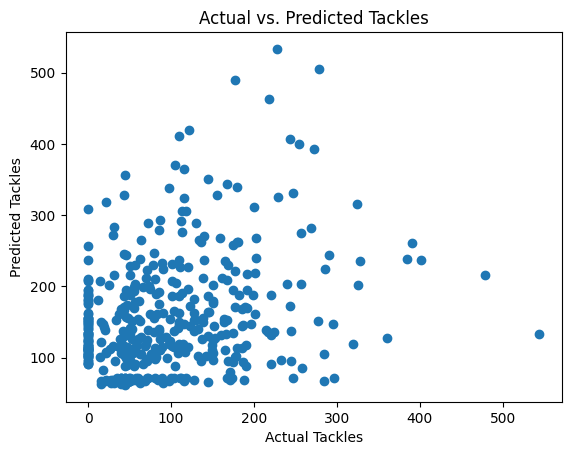

In [75]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Tackles')
plt.ylabel('Predicted Tackles')
plt.title('Actual vs. Predicted Tackles')
3plt.show()

### Results 

Unfortunately, we are failing to produce very good results here.  Eight games is just not enough data for to accurately predict results for each player.  It's also hard to come up with numerical variables on which we can predict, so we are a little limited in this context as well.